In [1]:
from math import log, exp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import (norm, lognorm, 
                         gamma, percentileofscore)

import seaborn as sns

# Section

## Subsection

lorem ipsum

[SciPy's](https://www.scipy.org) [*statistical submodule*](https://docs.scipy.org/doc/scipy/reference/stats.html)
[*norm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), 
[*lognorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html), 
[*beta*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), 
[*triang*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html), &
[*truncnorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html) continous distributions.

random variates method [*rvs( )*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html)

[*clip( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) method
[*describe( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe) method

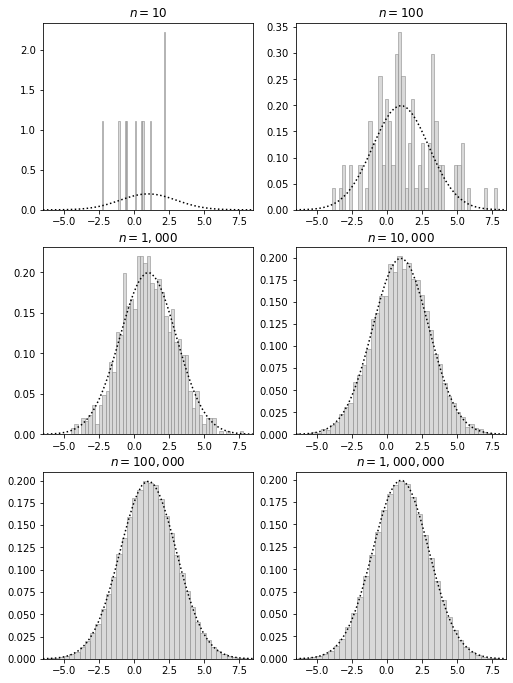

In [19]:
distribution = norm(loc=1, scale=2)
fig, ax = plt.subplots(3, 2, figsize=(8.3, 11.7))
ax = ax.flatten()
x = np.linspace(-6.5, 8.5)
y = distribution.pdf(x)
# for i, n in enumerate(np.logspace(5, 8, num=4, base=4)):
for i, n in enumerate(np.logspace(1, 6, num=6, base=10)):
    ax[i].hist(d.rvs(int(n)), bins=50, density=True,
               fc='0.85', ec='0.5', lw=0.5,)
    ax[i].set_title("$n={:,.0f}$".format(n))
    ax[i].plot(x, y, c='k', ls=':')
    ax[i].set_xlim(-6.5, 8.5)
plt.show()

In [3]:
def define_norm(P10, P90, **kwargs):
    mean = (P90+P10)/2 
    std = (P10-P90)/(norm.ppf(0.9)-norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def define_lognorm(P10, P90, **kwargs):
    std = log(P10 / P90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(P10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))

In [4]:
params = {
    'GRV':      define_lognorm(P90=10_000_000, P10=25_000_000),
    'NTG':      define_norm(P90=0.4, P10=0.6),
    'Porosity': define_norm(P90=0.125, P10=0.225),
    'Sw':       define_norm(P90=0.15, P10=0.45),
    'FVF':      define_norm(P90=1.1, P10=1.3),
    'RF':       define_norm(P90=0.15, P10=0.25),
}
realisations = pd.DataFrame([], columns=params)

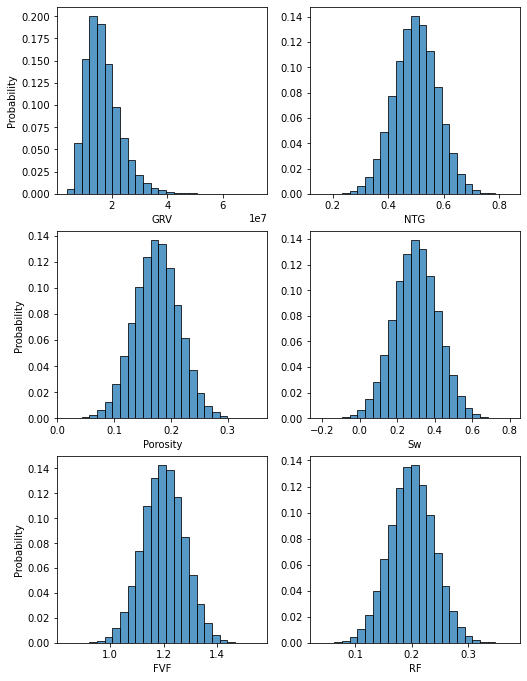

In [5]:
num_samples = 100_000

fig, ax = plt.subplots(nrows=(len(params) // 2 
                              + len(params) % 2),
                       ncols=2,
                       figsize=(8.3, 11.7))
ax = ax.flatten()

for i, (k, v) in enumerate(params.items()):
    x = v.rvs(num_samples)
    realisations[k] = x
    sns.histplot(data=realisations, x=k, ax=ax[i], 
                 stat='probability', bins=25,)
    if i % 2 == 1:
        ax[i].set_ylabel(None)
plt.show()

In [6]:
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.688722e+07,0.500132,0.175086,0.299413,1.199402,0.200025
std,6.261210e+06,0.078045,0.039073,0.116975,0.078273,0.039049
min,3.639881e+06,0.151289,0.016670,-0.216767,0.837096,0.036095
10%,1.000711e+07,0.400170,0.124903,0.149733,1.099277,0.149942
50%,1.583589e+07,0.500175,0.174961,0.298976,1.199247,0.199921
90%,2.506117e+07,0.599947,0.225161,0.449839,1.299648,0.250233
max,7.263248e+07,0.841734,0.352789,0.805311,1.551877,0.374777


In [8]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15)

In [10]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

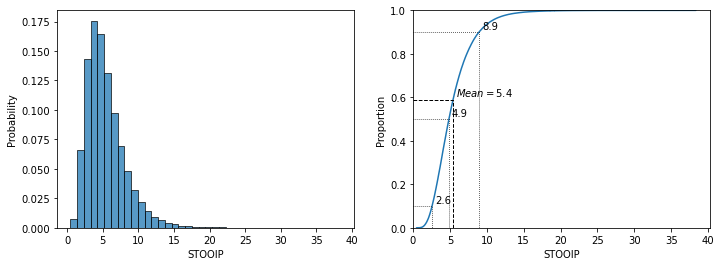

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(11.7,4))
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
sns.ecdfplot(realisations.STOOIP, ax=ax[1])
ax[1].set_xlim(left=0)
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               c='k', ls=":", lw=0.75)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels')
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(
    realisations.STOOIP,
    mean,
    kind='weak')/100
ax[1].plot([0] + [mean] * 2,
               [Pmean] * 2 + [0],
               c='k', ls="--", lw=1)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels')
plt.show()

In [66]:
def formatter(s):
    formats = {
        'Sw':       '{:.1%}',
        'Porosity': '{:.1%}',
        'FVF':      '{:.2}',
        'RF':       '{:.1%}',
        'GRV':      '{:,.1g}',
        'STOOIP':   '{:,.1f}',
        'Resource':  '{:,.1f}',
        'NTG':      '{:.1%}',
    }
    return(s.apply(formats[s.name].format))

def borders(s):
    fmt = 'border-top: 1px solid black; ' \
          + 'font-weight: bold'
    return [fmt for e in s]

summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],) \
    .apply(formatter).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary.style.apply(borders, axis=1, 
                    subset=pd.IndexSlice[['STOOIP', 'Resource'], :])

,Min,P90,P50,P10,Max,Mean
GRV,3e+06,1e+07,2e+07,3e+07,7e+07,2e+07
NTG,16.5%,40.0%,50.0%,60.0%,81.9%,50.0%
Porosity,6.0%,12.5%,17.5%,22.5%,29.1%,17.5%
Sw,10.1%,18.7%,30.4%,46.8%,59.9%,31.6%
FVF,0.86,1.1,1.2,1.3,1.5,1.2
RF,1.9%,15.0%,20.0%,25.0%,37.6%,20.0%
STOOIP,0.5,2.5,4.8,8.8,42.8,5.3
Resource,0.1,0.5,0.9,1.8,8.9,1.1


In [90]:
from IPython.display import Javascript
import urllib.parse

Javascript("const code = Jupyter.notebook.get_cell(1).get_text(); IPython.notebook.kernel.execute(`myvar = '${encodeURI(code)}'`);")
urllib.parse.unquote(myvar)

'# Section\n\n## Subsection\n\nlorem ipsum'

In [88]:
myvar

'#%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum'

In [92]:
import markdown

In [93]:
html = markdown.markdown(myvar)

In [94]:
html

'<h1>%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum</h1>'